In [1]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchinfo import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math
import random

Size of data_coins 500 : Size of labels_coins 500
Size of data_others 500 : Size of labels_others 500


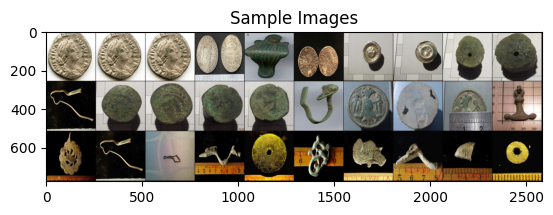

In [2]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"

def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=500)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=500)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images = 30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow = 10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [3]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size 
BATCH_SIZE = 10
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 700 : Each batch size 70
Total number of elements in val_loader: 150 : Each batch size 15
Total number of elements in test_loader: 150 : Each batch size 15


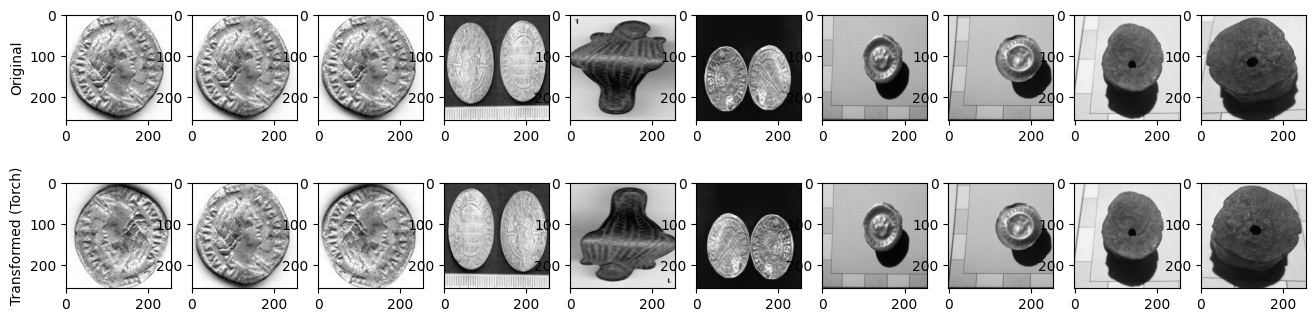

In [4]:
# Get a mini-batch from the train_loader and show differences before and after transformation
# Get the first 10 images from the train_loader
X, y = next(iter(coin_loader))

fig, axs = plt.subplots(2, 10, figsize=(16, 4))

# Loop over the first 10 images
for i in range(10):
    # Original images
    axs[0, i].imshow(coin_dataT[i, 0, :, :].detach().numpy(), cmap='gray')
    # Transformed images
    axs[1, i].imshow(X[i, 0, :, :].detach().numpy(), cmap='gray')

# Set labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Transformed (Torch)')

plt.show()

In [20]:
toggle_print = True # Change to 'True' to print information of the model

# Hyperparameters 
d_model = 768 # 16x16 number of patches times the number of channels
n_heads = 8 # Multihead attention layer
dim_feedforward = 4096 # default
activation='gelu' # Activation function
batch_first = False
norm_first = True # Normalize before each encoder layer
bias = True
dropout = 0.1
layer_norm = nn.LayerNorm(d_model)
n_classes = 1 # either 0 or 1. Do not change
n_layers = 8 # Encoder (simular) layers
n_image_channels = 3 # RGB 
max_n_patches = 256 # 16x16
patch_size = 16 # -> 16x16
n_hidden = 2 # FFN hidden layers
learning_rate = 0.01

# Using the convolution kernel for ease of implementation and patch embeddings - First step
# Using a Conv2d layer for linear projection it becomes a hybrid model
class PatchEmbeddings(nn.Module):
    def __init__(
        self,
        d_model: int, 
        patch_size: int, 
        in_channels: int 
    ):
        super().__init__()

        # Sliding window approach - Size(Kernel)=Size(Stride)
        self.conv = nn.Conv2d(
            in_channels = in_channels, # 3 channel: RGB
            out_channels = d_model, # 256 * 3 -> Each patch becomes one 'pixel' and will have 3 values in embedding space i.e. 768 d_model
            kernel_size = patch_size, 
            stride = patch_size
        )

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        bs, c, h, w = x.shape
        print(f'Shape of x after convolution: {x.shape}') if toggle_print else None
        x = x.permute(2, 3, 0, 1)
        x = x.view(h * w, bs ,c)
        print(f'Shape of x after convolution and permutation: {x.shape}') if toggle_print else None
        return x
        

# Relative positional Encoding - Second step
class PositionalEmbedding(nn.Module): 
    def __init__(
        self, 
        d_model: int, 
        max_len: int = 256 # Number of maximum patches - 256 = 16x16 patches 
    ):
        super().__init__()

        self.positional_encodings = nn.Parameter(
            torch.zeros(
                max_len, 
                1, 
                d_model
            ), 
            requires_grad = True)

    def forward(self, x: torch.Tensor):
        # pe = tensor of length 256 to match input size of x, d_model is still preserved and added to x
        pe = self.positional_encodings[:x.shape[0]]
        return x + pe

# The classification step (last step)
class ClassificationHead(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        n_hidden: int, 
        n_classes: int
    ):
        super().__init__()

        self.linear1 = nn.Linear(
            in_features = d_model, 
            out_features = n_hidden,
            bias = True
        ) 
        self.act = nn.ReLU() 
        self.linear2 = nn.Linear(
            in_features = n_hidden, 
            out_features = n_classes,
            bias = True
        ) # Last - Predicts

    def forward(self, x: torch.Tensor):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x

# Our transformer model i.e. contains the encoder - middle step
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        n_layers: int, # Number of transformer layers
        patch_emb: PatchEmbeddings, # patch embedding layers
        pos_emb: PositionalEmbedding,  # PE 
        classification: ClassificationHead # Classification head
    ):
        super().__init__()

        self.patch_emb = patch_emb # x is passed to patch_emb
        self.pos_emb = pos_emb # x is passed to pos_emb
        self.classification = classification

        self.transformer_encoder_layer = nn.TransformerEncoderLayer( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
            d_model = d_model,
            nhead = n_heads,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            activation = activation, # GeLU is recommended
            batch_first = batch_first,
            norm_first = norm_first,
            bias = bias
        )
        self.transformer_encoder = nn.TransformerEncoder( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
            encoder_layer = self.transformer_encoder_layer,
            num_layers = n_layers, # n times encoder layers (above)
            norm = layer_norm
        )
        
        # Init class tokens for each batch element of input x
        self.class_tokens = nn.Parameter(
            torch.rand(
                (1, 1, d_model), 
                requires_grad=True
            )
        ) # Learnable class token for each element in batch

        self.ln = nn.LayerNorm([d_model])
        
        print(f'Class token: {self.class_tokens.data}') if toggle_print else None
        print(f'Shape of class token: {self.class_tokens.shape}') if toggle_print else None
        
        
    def forward(self, x: torch.Tensor):

        x = self.patch_emb(x)

        class_tokens = self.class_tokens.expand(-1, x.shape[1], -1)
        x = torch.cat([class_tokens, x])

        x = self.pos_emb(x)

        x = self.transformer_encoder(x)

        x = self.ln(x)

        x = self.classification(x)

        return x

# Model
vit_model = VisionTransformer(
    n_layers = n_layers, 
    patch_emb = PatchEmbeddings( # Patch emb
        d_model = d_model, 
        patch_size = patch_size, 
        in_channels = n_image_channels
    ), 
    pos_emb = PositionalEmbedding( # Positional encoding
        d_model = d_model,
        max_len = max_n_patches
    ), 
    classification = ClassificationHead( # Classification head 
        d_model = d_model, 
        n_hidden = n_hidden, 
        n_classes = n_classes
    )
)

# Loss function
loss_func = nn.BCEWithLogitsLoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))

# Optimizer 
optimizer = Adam(
    vit_model.parameters(), 
    lr = learning_rate
)

# Summary of the model - https://pypi.org/project/torchinfo/
summary(
    model = vit_model,
    input_size = (
        BATCH_SIZE, 3, 256, 256),  # c, h, w
    verbose = 1,  # 2 for full info
    col_names = [
        "input_size", 
        "num_params", 
        "output_size", 
        "mult_adds", 
        "trainable"
    ],
    mode = "train"
)

Class token: tensor([[[9.9279e-02, 9.5137e-01, 2.7251e-01, 9.2324e-01, 2.0513e-01,
          1.3765e-01, 6.2014e-01, 6.9307e-01, 2.5366e-01, 3.5450e-02,
          1.3706e-01, 8.8614e-01, 6.9391e-01, 7.2626e-01, 6.5377e-01,
          2.9065e-01, 6.5155e-01, 4.6221e-01, 9.1593e-01, 5.1148e-01,
          7.5953e-01, 4.2849e-01, 9.3480e-01, 7.4892e-01, 8.1110e-01,
          4.0858e-01, 6.9290e-01, 1.6578e-03, 8.7658e-01, 5.1149e-01,
          9.8542e-01, 5.7371e-01, 5.8232e-01, 8.4687e-01, 5.4330e-01,
          6.2459e-01, 4.4158e-02, 9.3152e-02, 4.1372e-02, 4.9785e-01,
          5.1629e-01, 1.3470e-01, 2.2385e-01, 7.3777e-01, 2.3090e-01,
          3.6872e-01, 5.8311e-01, 4.0669e-01, 4.8069e-01, 3.6588e-01,
          7.6268e-01, 9.9139e-01, 5.6652e-01, 7.6831e-01, 5.0081e-01,
          4.2997e-01, 7.6729e-01, 1.8606e-01, 6.4073e-01, 7.5639e-01,
          7.3046e-01, 7.8754e-01, 3.7422e-01, 1.4705e-01, 6.7927e-01,
          7.2896e-04, 4.7797e-01, 9.4555e-01, 6.7086e-01, 9.6935e-01,
       

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [PatchEmbeddings: 1, Conv2d: 2]

In [8]:
# Train the model on a minibatch for testing
from torch.optim import Adam
import torch
import gc
# Metrics library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters
num_epochs = 10
threshold = 0.5

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {num_gpus}")
    vit_model = vit_model.cuda()
else:
    print("CUDA is not available. Using CPU.")

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect() # Call garbage collector (gc)

def validate(model, loss_func, val_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target = data
            # Move input data to GPU if CUDA is available
            if cuda_available:
                inputs, target = inputs.cuda(), target.cuda()
                
            output = model(inputs)
            predictions = output[:,-1,:] # Extract only the batches and preditions and ignore the patches. Convert the long type to float
            loss = loss_func(predictions, target.float())
            total_loss += loss.item() 
            
            preds = torch.sigmoid(predictions) > threshold # Threshold is used to determine the predicted value - 0 or 1 based on threshold value
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # https://scikit-learn.org/stable/modules/model_evaluation.html
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(
        all_targets, 
        all_preds, 
        zero_division = 0,
        average = 'binary'
    )
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    return avg_loss, accuracy, precision, recall, f1

# Training loop
def train(
    model, 
    loss_func, 
    optimizer, 
    train_loader,
    val_loader, 
    # test_loader,
    num_epochs = num_epochs,
):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        # Iterate over dataset
        for i, data in enumerate(train_loader, start = 0):
            inputs, target = data # target shape: [BATCH_SIZE,1]
            
            # Move input data to GPU if CUDA is available
            if cuda_available:
                input_data, target = inputs.cuda(), target.cuda()
            
            optimizer.zero_grad() # Instanitate optimizer
            output = model(input_data)
            predictions = output[:,-1,:] # Extract only the batches and preditions and ignore the patches. Convert the long type to float

            '''
            # Print intermediate results for debugging
            print(f'Output (first batch): {output.detach().cpu().numpy()}')
            print(f'Predictions (first batch): {predictions.detach().cpu().numpy()}')
            print(f'Targets (first batch): {target.detach().cpu().numpy()}')
            '''
            
            loss = loss_func(predictions, target.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation call
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(
            model = vit_model,
            loss_func = loss_func, 
            val_loader = val_loader
        )

        # Append metrics to lists
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1)

        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Training Loss: {avg_loss:.4f} - '
              f'Validation Loss: {val_loss:.4f} - '
              f'Validation Accuracy: {val_accuracy:.4f} - '
              f'Validation Precision: {val_precision:.4f} - '
              f'Validation Recall: {val_recall:.4f} - '
              f'Validation F1 Score: {val_f1:.4f}')

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    
    # Plot Training and Validation Losses
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy, Precision, Recall, and F1 Score
    plt.subplot(2, 1, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.title('Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    ''' TODO:
    # Testing call 
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(
        model = vit_model,
        loss_func = loss_func, 
        test_loader = test_loader
    )
    '''

# Clear GPU memory before training run - clear GPU cache from previous run 
clear_gpu_memory()

# Training, validation and testing init
train(
    model = vit_model, 
    loss_func = loss_func, 
    optimizer = optimizer, 
    num_epochs = num_epochs,
    train_loader = train_loader,
    val_loader = val_loader
)

CUDA is available. Number of GPUs: 1


ValueError: Classification metrics can't handle a mix of binary and continuous targets